<a href="https://colab.research.google.com/github/Bharatvyas12/CNN-based-Pnemonia-system-by-vgg16/blob/main/vgg16%20for%20pnemonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==1.2.2 xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
!pip install tensorflow \pandas numpy opencv-python --quiet

# ----- KAGGLE DATA DOWNLOAD (AS YOU DID BEFORE) -----
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

# =================================================================
# STEP 2: DATA PREPROCESSING (70-30 SPLIT)
# =================================================================
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_all_images():
    base_dir = '/content/chest_xray'
    classes = ['NORMAL', 'PNEUMONIA']
    images = []
    labels = []

    # Load from ALL folders (train+test+val)
    for folder in ['train', 'test', 'val']:
        for class_name in classes:
            path = os.path.join(base_dir, folder, class_name)
            class_idx = 0 if class_name == 'NORMAL' else 1

            for img_name in os.listdir(path):
                try:
                    img = cv2.imread(os.path.join(path, img_name))
                    img = cv2.resize(img, (150, 150))
                    img = img / 255.0  # Normalize
                    images.append(img)
                    labels.append(class_idx)
                except:
                    continue  # Skip corrupt files

    return np.array(images), np.array(labels)

# Load and split (70-30)
X_all, y_all = load_all_images()
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

print(f"\nDataset Shapes:")
print(f"Total: {X_all.shape} | Train: {X_train.shape} | Test: {X_test.shape}")

Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:19<00:00, 164MB/s]
100% 2.29G/2.29G [00:19<00:00, 127MB/s]

Dataset Shapes:
Total: (5856, 150, 150, 3) | Train: (4099, 150, 150, 3) | Test: (1757, 150, 150, 3)


In [ ]:
# Install dependencies (already done in your command, but included for completeness)
!pip install tensorflow pandas numpy opencv-python --quiet

# Import libraries
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image
import os

# Constants
IMG_SIZE = (224, 224)  # VGG16 input size
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 1  # Binary classification (pneumonia vs normal)

# Dataset paths (after unzipping chest-xray-pneumonia.zip)
base_dir = "/content/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# 1. Data Preprocessing with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation/test

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary labels: 0 = NORMAL, 1 = PNEUMONIA
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Print class indices for confirmation
print("Class indices:", train_generator.class_indices)

# 2. Build VGG16-based CNN Model
def build_model():
    # Load VGG16 pre-trained on ImageNet, exclude top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze base model layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  # Prevent overfitting
    predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)  # Binary output

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

model = build_model()
model.summary()

# 3. Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)

# 4. Fine-Tune Model (Unfreeze top layers)
for layer in model.layers[-5:]:  # Unfreeze last 5 layers
    layer.trainable = True

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])

# Fine-tune
fine_tune_epochs = 5
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=fine_tune_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)

# 5. Evaluate Model
test_loss, test_accuracy, test_recall = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}")



# 6. Prediction Function
def predict_pneumonia(image_path, model):
    """Predict if an image shows pneumonia."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img = np.array(img) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)[0][0]
    result = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return result, confidence


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 771ms/step - accuracy: 0.8211 - loss: 0.6880 - recall: 0.8873 - val_accuracy: 0.7500 - val_loss: 0.4546 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 669ms/step - accuracy: 0.9085 - loss: 0.2249 - recall: 0.9385 - val_accuracy: 0.8125 - val_loss: 0.4396 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 676ms/step - accuracy: 0.9203 - loss: 0.1953 - recall: 0.9459 - val_accuracy: 0.7500 - val_loss: 0.5402 - val_recall: 1.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 666ms/step - accuracy: 0.9210 - loss: 0.1963 - recall: 0.9553 - val_accuracy: 0.7500 - val_loss: 0.4138 - val_recall: 1.0000
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 670ms/step - accuracy: 0.9270 - loss: 0.1874 - recall: 0.9516 - val_accuracy: 0.8125 - val_loss: 0.3295 - val_recall: 1.0000
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 668ms/step - accuracy: 0.9290 - loss: 0.1766 - recall: 0.9518 - val_accuracy: 0.8125 - val_loss: 0.2594 -

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MODEL_PATH = '/content/drive/MyDrive/pneumonia_model.h5'  # Saves in your Google Drive

# Save the trained model
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/pneumonia_model.h5


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_dir = '/content/chest_xray/test'
val_test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Starting evaluation...
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step
Number of predictions: 624
Number of true labels: 624


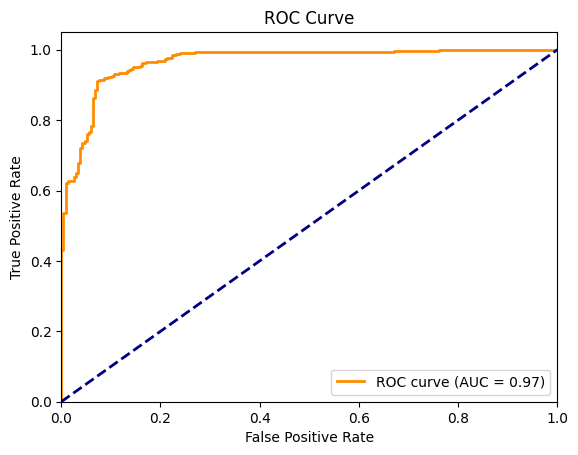

ROC curve displayed


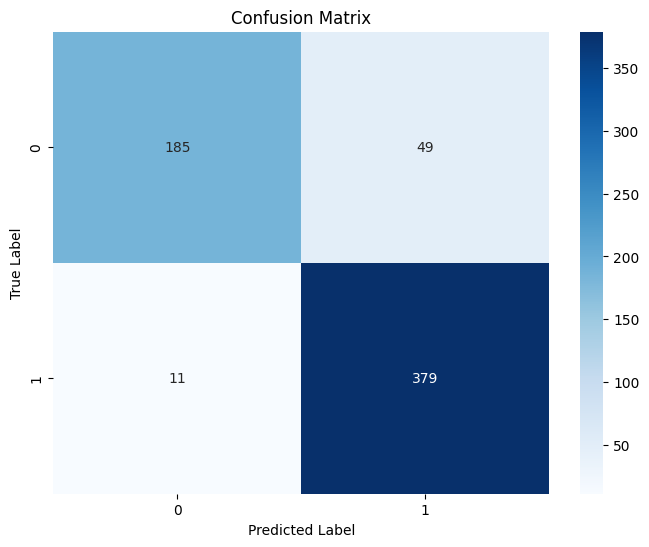

Confusion matrix displayed
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.8649 - loss: 0.3977 - recall_1: 0.6443
Metrics returned: [0.2745707631111145, 0.9038461446762085, 0.971794843673706]
Unexpected number of metrics returned. Check model compilation.
Raw metrics: [0.2745707631111145, 0.9038461446762085, 0.971794843673706]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Normal, Confidence: 0.9865


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants (ensure these match your model)
IMG_SIZE = (224, 224)  # Must match your model's input size
BATCH_SIZE = 32

# Set up test generator
test_dir = '/content/chest_xray/test'
val_test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load your model
model = tf.keras.models.load_model('/content/drive/MyDrive/pneumonia_model.h5')  # Ensure this path is correct

# Prediction Function
def predict_pneumonia(image_path, model):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)[0][0]
    result = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return result, confidence

# Plot Metrics Function with Debugging
def plot_metrics(model, test_generator):
    print("Starting evaluation...")  # Debug: Confirm function starts

    # Reset generator and get predictions
    test_generator.reset()
    y_pred_proba = model.predict(test_generator, verbose=1)  # verbose=1 shows progress
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_true = test_generator.classes

    # Debug: Check data lengths
    print(f"Number of predictions: {len(y_pred_proba)}")
    print(f"Number of true labels: {len(y_true)}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("ROC curve displayed")  # Debug: Confirm plot

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("Confusion matrix displayed")  # Debug: Confirm plot

    # Metrics
    test_generator.reset()  # Reset before evaluation
    metrics = model.evaluate(test_generator, verbose=1)  # verbose=1 shows progress
    print(f"Metrics returned: {metrics}")  # Debug: Raw metrics output

    # Unpack metrics based on what the model was compiled with
    if len(metrics) == 4:  # Assuming loss, accuracy, recall, precision
        test_loss, test_accuracy, test_recall, test_precision = metrics
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        print(f"Test Precision: {test_precision:.4f}")
    else:
        print("Unexpected number of metrics returned. Check model compilation.")
        print(f"Raw metrics: {metrics}")

# Execute the function
plot_metrics(model, test_generator)

# Example prediction
image_path = '/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg'  # Replace with valid path
result, confidence = predict_pneumonia(image_path, model)
print(f"Prediction: {result}, Confidence: {confidence:.4f}")


Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Calling plot_metrics...
Starting plot_metrics...
Test generator samples: 624
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step
Predictions shape: (624, 1)
True labels length: 624


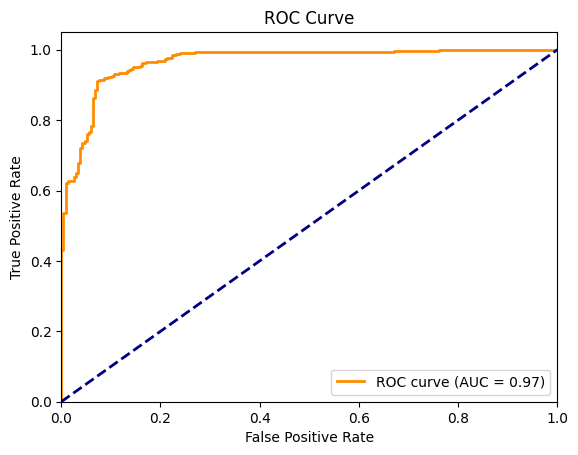

ROC curve should be displayed


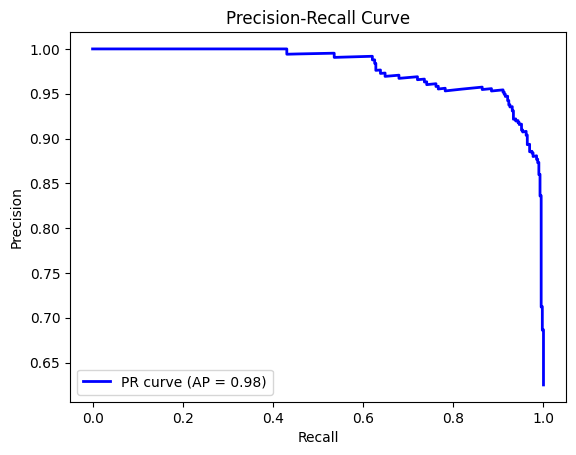

Precision-Recall curve should be displayed


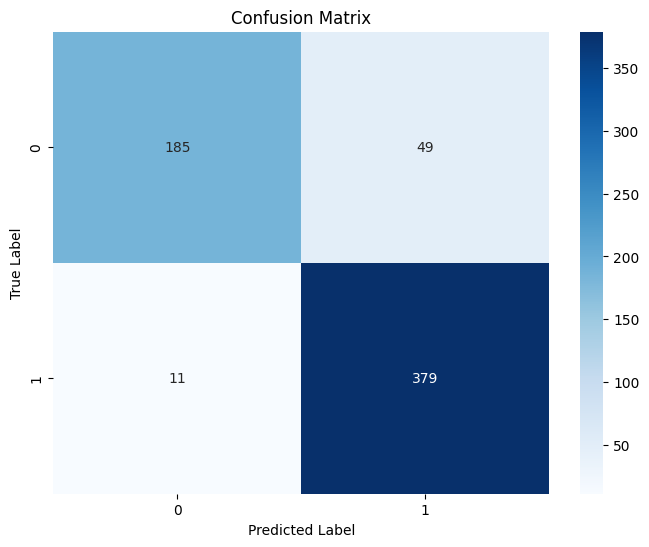

Confusion matrix should be displayed
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.8649 - loss: 0.3977 - recall_1: 0.6443
Raw metrics from evaluate: [0.2745707631111145, 0.9038461446762085, 0.971794843673706]
Unexpected metrics count: 3. Raw metrics: [0.2745707631111145, 0.9038461446762085, 0.971794843673706]
Specificity: 0.7906
F1-Score: 0.9267

Class-wise Performance:
              precision    recall  f1-score   support

      Normal       0.94      0.79      0.86       234
   Pneumonia       0.89      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Prediction: Normal, Confidence: 0.9865


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, precision_recall_curve, average_precision_score, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Set up test generator
test_dir = '/content/chest_xray/test'
val_test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/pneumonia_model.h5')  # Verify this path exists

# Prediction Function
def predict_pneumonia(image_path, model):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)[0][0]
    result = "Pneumonia" if prediction > 0.5 else "Normal"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return result, confidence

# Plot Metrics Function with Debugging
def plot_metrics(model, test_generator):
    print("Starting plot_metrics...")  # Debug: Confirm function starts

    # Verify generator data
    print(f"Test generator samples: {test_generator.samples}")
    if test_generator.samples == 0:
        print("Error: No images found in test_generator!")
        print(f"Contents of {test_dir}: {os.listdir(test_dir)}")
        return

    # Reset and predict
    test_generator.reset()
    y_pred_proba = model.predict(test_generator, verbose=1)
    print(f"Predictions shape: {y_pred_proba.shape}")  # Debug: Check prediction output
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_true = test_generator.classes
    print(f"True labels length: {len(y_true)}")  # Debug: Check true labels

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("ROC curve should be displayed")  # Debug: Confirm plot

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    print("Precision-Recall curve should be displayed")  # Debug: Confirm plot

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("Confusion matrix should be displayed")  # Debug: Confirm plot

    # Additional Metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred)

    # Evaluate
    test_generator.reset()
    metrics = model.evaluate(test_generator, verbose=1)
    print(f"Raw metrics from evaluate: {metrics}")  # Debug: Show raw output

    if len(metrics) == 4:
        test_loss, test_accuracy, test_recall, test_precision = metrics
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        print(f"Test Precision: {test_precision:.4f}")
    else:
        print(f"Unexpected metrics count: {len(metrics)}. Raw metrics: {metrics}")

    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClass-wise Performance:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Execute the function
print("Calling plot_metrics...")
plot_metrics(model, test_generator)

# Example prediction
image_path = '/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg'  # Verify this path exists
result, confidence = predict_pneumonia(image_path, model)
print(f"Prediction: {result}, Confidence: {confidence:.4f}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MODEL_PATH = '/content/drive/MyDrive/pneumonia_model.h5'  # Saves in your Google Drive

# Save the trained model
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/pneumonia_model.h5
